**Save this file as studentid_lab1.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if your student-id is 12345678, then:
12345678_lab1.ipynb.

**This will be parsed by a regexp, so please double-check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in your code when you will see the following tags: begin solution and end solution**

# Lab 1 - Maximum likelihood estimation, Linear Regression and Overfitting


## Machine Learning 1, September/October 2023

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your TA.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
*Use the provided test boxes to check if your answers are correct.
* **Do not change the arguments in our functions!**
* **Do not remove or add new cells. If you do you should expect a penalty in your assignment!**

## Relevant materials for this assignment

* Material week 1-3

In [1]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '3.5.1'), 
               ('numpy', '1.22.3'), 
               ('python', '3.9.5'), 
               ('sklearn', '1.1.1'), 
               ('scipy', '1.7.3'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

##  Maximum likelihood estimation

### Probability theory (Background)
In this section, we will formalize and refresh the basic notions of probability theory. Even though these notions are basic in the sense that they are used often and lie at the basis of all probability theory and statistics, they are quite tricky to fully grasp. Taking your time now to digest these notions will pay off later :)


#### Sample spaces and event spaces


Suppose that after a lecture, I randomly select one student from the course and record whether they are right-handed or left-handed, and then have them randomly select a student and again I record whether they are right-handed or left-handed. Of course, this experiment has a random element to it: if I repeat it multiple times, I can get different outcomes. We will use this experiment as our guiding example to introduce all notions. 

First of all, we can define a **sample space**. In essence, a sample space - denoted as $\Omega$ - is just a set of possible outcomes we agree on. In our case, $\Omega = \{\text{RR}, \text{RL}, \text{LR}, \text{LL}\}$, where 'LR' denotes that person one is left-handed and person two is right-handed, et cetera. Slightly more technical, we need to define an **event space**. That is, we need to choose to which subsets of the sample space - or, **events** - we care to assign probabilities. If in our so-called event space - denoted $\mathcal{S}$ - we want to assign a probability to $\{ \text{LR}, \text{RL} \}$ - i.e. the event that there is exactly one left-handed person - we need to ensure that $\{ \text{LR}, \text{RL} \} \in \mathcal{S}$. This event space needs to satisfy a few requirements to ensure you can do regular probability theory:


1.   The empty set is an event, i.e. $\emptyset \in \mathcal{S}$.
2.   If the union of two events is also an event, i.e. $\alpha, \beta \in \mathcal{S}$ implies that $\alpha \cup \beta \in \mathcal{S}$.
3.   The complement of some event is also an event, i.e. $\alpha \in \mathcal{S}$ implies that $\Omega \setminus \alpha \in \mathcal{S}$. 

Since $\mathcal{S}$ is closed under these operations, it is also closed under other Boolean operations, such as intersection and set difference since we can define these operations in terms of unions and complements.


#### Random variables and probability distributions



One of the most important notions in probability theory is a **random variable**. You can think of a random variable as asking a question about this experiment, e.g. we might be interested in how many left-handed people there are in each experiment. What a random variable simply does, is tell us the answer to that question for each of the outcomes in the sample space, i.e. if we denote our random variable as $\text{TotalLH}$, we would say that 

- $\text{TotalLH}(\text{RR}) = 0$, 
- $\text{TotalLH}(\text{RL}) = \text{TotalLH}(\text{LR}) = 1$, 
- $\text{TotalLH}(\text{LL}) = 2$. 

Note that therefore a random variable is not a variable but rather a function that maps from $\Omega$ into $\mathbb{R}$ in general. Also, since this mapping isn't random either, both 'random' and 'variable' do not make too much intuitive sense for this object. There is also a reverse mapping for this. Since 

$$\text{TotalLH}(\text{RL}) = \text{TotalLH}(\text{LR}) = 1,$$ 

we can also write that 

$$(\text{TotalLH} = 1) = \{\text{LR, RL}\}.$$

This may look unfamiliar at first, but you have used this before very often: every time you write $P(X=x)$, you are considering the probability of the event described by the set $(X=x)$. 


Now, the last object we care about is a **probability distribution**. A probability distribution $P$ is a function that describes the probability of a random variable taking certain values. Assuming that roughly 10% of people are left-handed, we will guess for now that the probability of our experiment having only left-handed people is 0.01. This we would write as $P(\text{TotalLH} = 2) = 0.01$. Please note that therefore a probability distribution is mapped from $P: \mathcal{S} \to \mathbb{R}$. Formally, a probability distribution $P$ over $(\Omega, \mathcal{S})$ is a mapping from $\mathcal{S}$ to real values that satisfies:

1. All probabilities are non negative, i.e. $P(\alpha) \geq 0$ for all $\alpha \in \mathcal{S}$
2. The 'maximum' probability of the event that 'anything happens' is 1, i.e. $P(\Omega) = 1$
3. The probability that one of two disjoint events will occur is the sum of the probabilities of each event, i.e. $\alpha, \beta \in \mathcal{S}$ and $\alpha \cap \beta = \emptyset$, then $P(\alpha \cup \beta) = P(\alpha) + P(\beta)$.

These are the so-called **Kolmogorov Axioms**. You can read more about them here: https://en.wikipedia.org/wiki/Probability_axioms


#### Why do we care? 

What is especially nice about looking at distributions for different random variables, is that we can find patterns in them / realize that different processes follow the same kind of distribution. For example, a random coin flip versus asking someone whether they're left-handed both follow the same kind of distribution, since both random variables assign probabilities to exactly two outcomes (even though the exact distributions might be different, i.e. the odd of getting heads in not necessarily the same as the odds of getting a right-handed person). This distribution is called a Bernoulli distribution. If the probability of a positive outcome for the random variable $\text{X}$ is denoted as $p$, we write that $\text{X} \sim \mathsf{Bernoulli}(p)$. So, our coin flip would follow a $\mathsf{Bernoulli}(0.5)$, and out right-handedness experiment would follow a $\mathsf{Bernoulli}(0.9)$, but both are Bernoullis. Here, you can find a list of many existing distributions: https://en.wikipedia.org/wiki/List_of_probability_distributions 

As you may guess, we say that $p=0.5$ because half of the time we flip a coin it lands on heads. But why is this a valid way of estimating that probability? That is exactly what we formalize with MLE.

### Implementing MLE Poisson distribution
One of the most common distributions that assign a probability of all outcomes $n \in \mathbb{N}$ is the Poisson distribution. The Poisson distribution in general is used to assign probabilities to a random variable that describes the **number of events in a fixed interval of time/space**, e.g. how many emails you get per hour or the number of people that arrive to your restaurant per minute. We say that $\text{X} \sim \mathsf{Poisson}(\lambda)$ when

$$P(X=k) = \frac{\lambda^k e^{-\lambda}}{k!}.$$

This is what this distribution looks like for different values of $\lambda$:

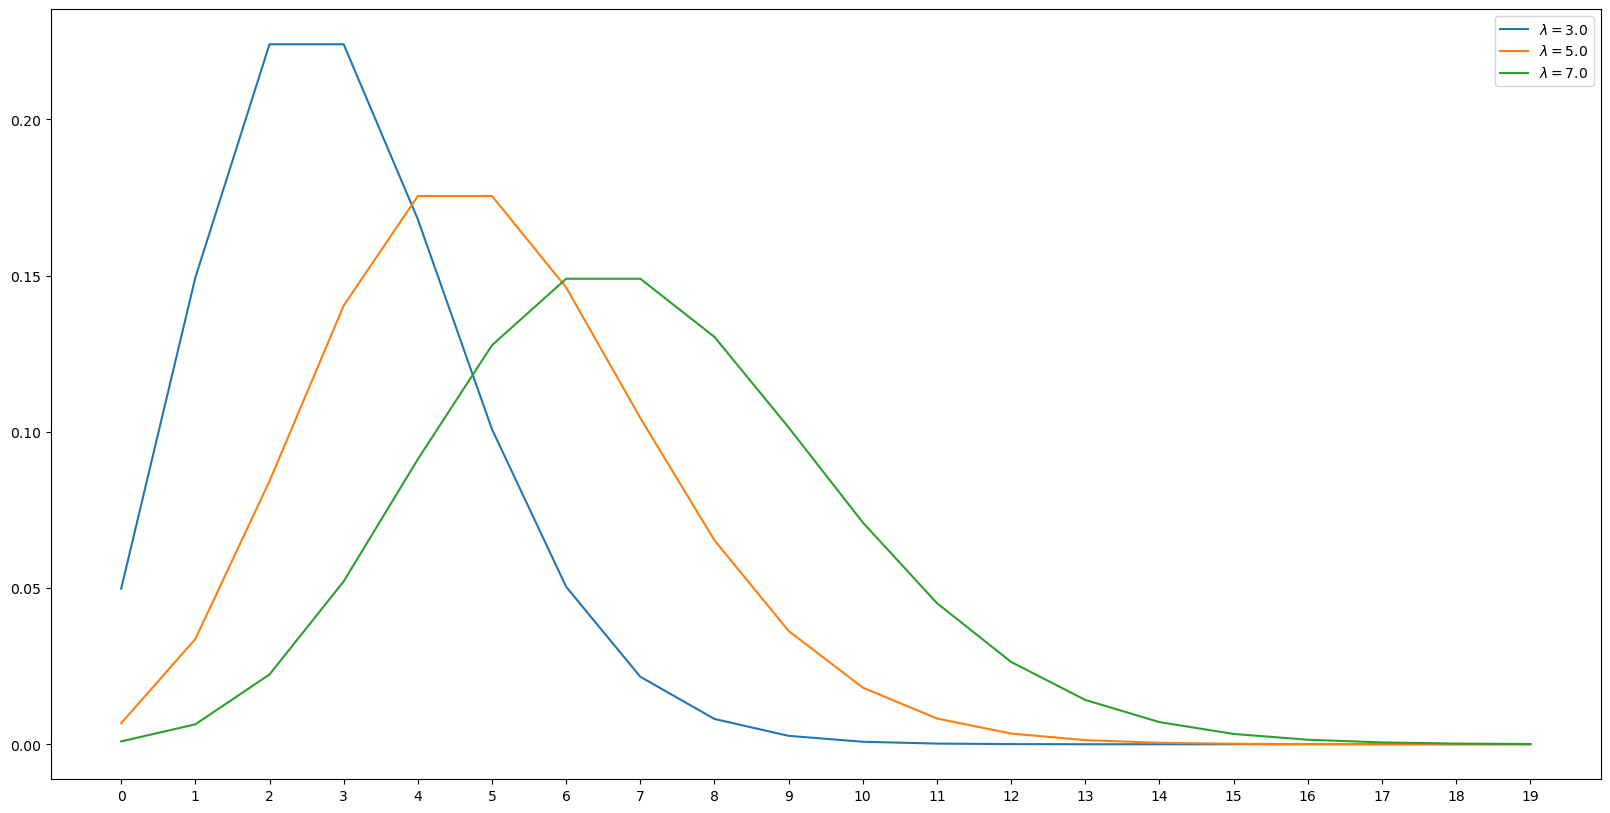

In [3]:
from scipy.stats import poisson

support = np.arange(20)
lambda_values = [3.0, 5.0, 7.0]

for lambda_value in lambda_values:
    val = poisson.pmf(support, lambda_value)
    plt.plot(support, val, label=f'$\lambda={lambda_value}$')

plt.xticks(support)
plt.legend()
plt.show()


### Implement log-likelihood (5pt)
In the lectures, we have come across the likelihood and log-likelihood function. Implement the log likelihood function for the poisson distribution:

In [4]:
from scipy.special import factorial

def log_likelihood(lam, obs):
    # YOUR CODE HERE
    llh = []
    N = obs.shape[0]
    factorials = [math.factorial(x) for x in obs]
    for lambda_value in lam:
#         llh.append(np.sum(np.log(poisson.pmf(obs, lambda_value))))
        llh.append(-N*lambda_value + np.log(lambda_value)*np.sum(obs)-np.sum(np.log(factorials)))
    return np.array(llh)

In [5]:
# Test your function

lam = 3.5
observations = np.random.poisson(lam, size=500)
lambda_values = np.linspace(1, 10, 1000)

llh = log_likelihood(lambda_values, observations)
assert llh.shape == (len(lambda_values,),), "the shape of log-likelihoods is incorrect"




In these cases, it can be worth to check yourself. When you plot the log likelihood, is the most likely value for lambda actually the value we specified? 

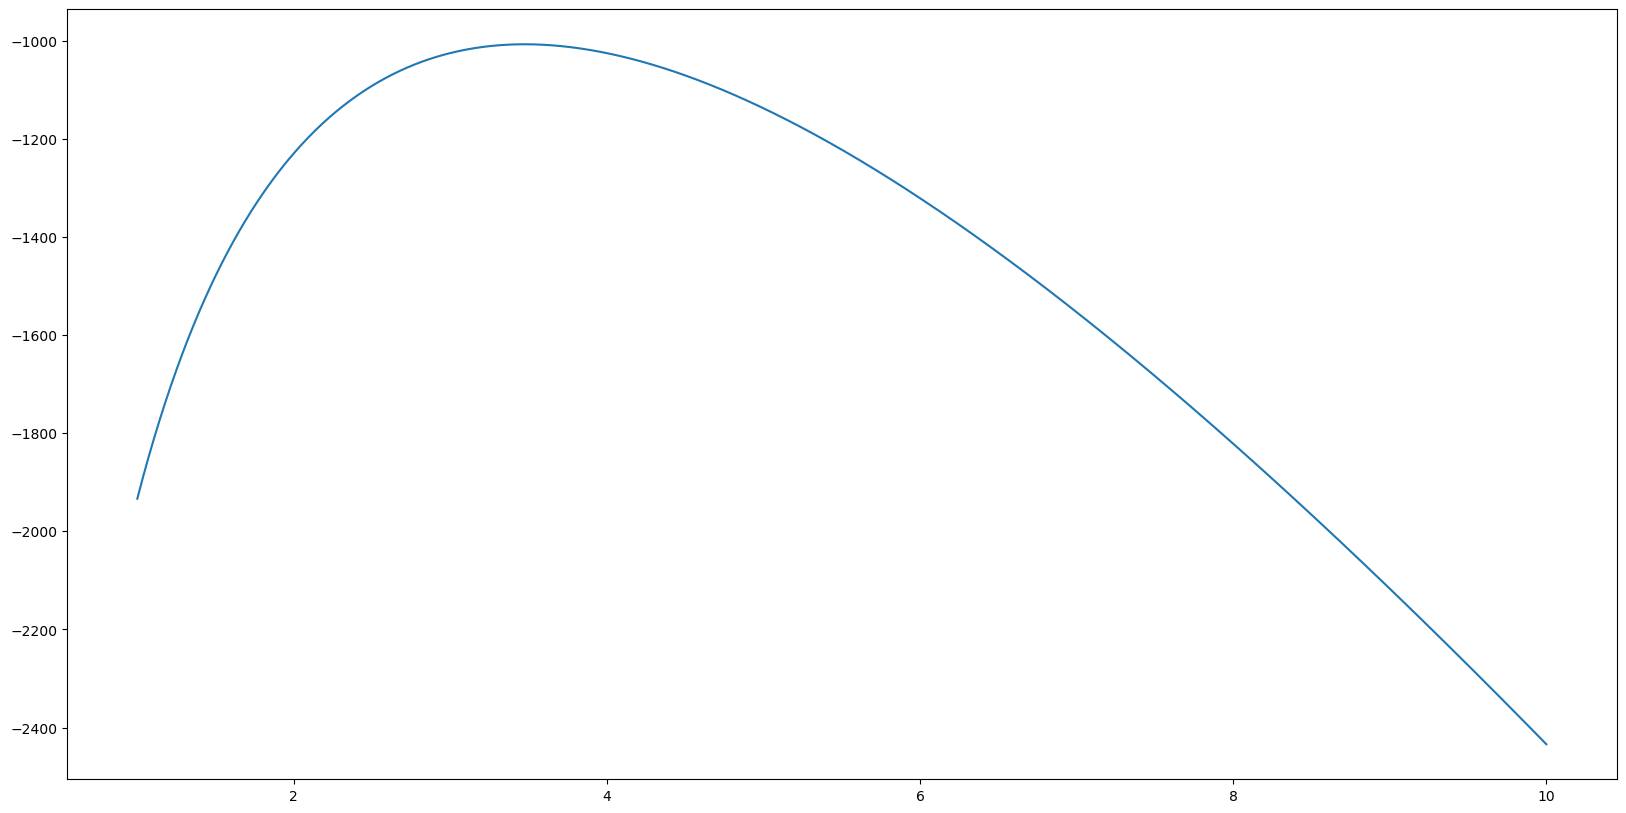

In [6]:
plt.plot(lambda_values, log_likelihood(lambda_values, observations))

### Implement MLE for Poisson (5pt)

In class, you learned how to compute the MLE. Implement the MLE for $\lambda$ in the Poisson distribution here:

In [7]:
def mle_poisson(obs):
    """Return MLE estimate of lambda parameter of a set of observations."""
    # YOUR CODE HERE
    mle = np.mean(obs)
    
    return mle

Again, you can check yourself. In the following cell, you can test if your MLE estimate is close to the lambda value specified:

In [10]:
mle = mle_poisson(observations)
print(mle)



3.474


### Parametrizing distributions (5pt)

Suppose we want to predict is given student will do pass the exam. The most basic thing we could do is define a random variable $\text{DoesWell}$ that follows a Bernoulli distribution with the pass rate of the exam, e.g. if 80% of student pass we can say that for any student $\text{DoesWell} \sim \mathsf{Bernoulli}(0.8)$. However, sometimes we may have information about a student, e.g. their average grade for the courses thusfar, and we want to use that information. So, we want to find a distribution $\text{DoesWell} \mid \text{Grade}$. Maybe, we want to say that if a student has a $10$, they are 95% likely to pass the exam, if their grade is a $9$ they are 85% likely to pass the exam, et cetera. That is, we say that 

$$\text{DoesWell} \mid \text{Grade}=g \sim \mathsf{Bernoulli}(\frac{g - 0.5}{10}).$$

Please note that in general we can use other functions $f$ to parameterize $Y \mid X = x \sim \mathsf{Bernoulli}(f(x))$, e.g. a neural network.

For each grade, sample from this Bernoulli distribution. You should use `np.random.binomial`.


In [11]:
def sample_bernoulli(grades):
    # YOUR CODE HERE
    does_wells = np.random.binomial(1, (grades - 0.5) / 10)
    return does_wells

In [12]:
np.random.seed(42)
grades = np.random.randint(1, 11, 100)
does_wells = sample_bernoulli(grades)

assert does_wells.shape == (len(grades), )


As a sanity check: how many people did well that had a ten for the assignments? And what about people that had a one?

People who had 10 for the assignment: 9
People who had 1 for the assignment: 0


Text(0, 0.5, 'People')

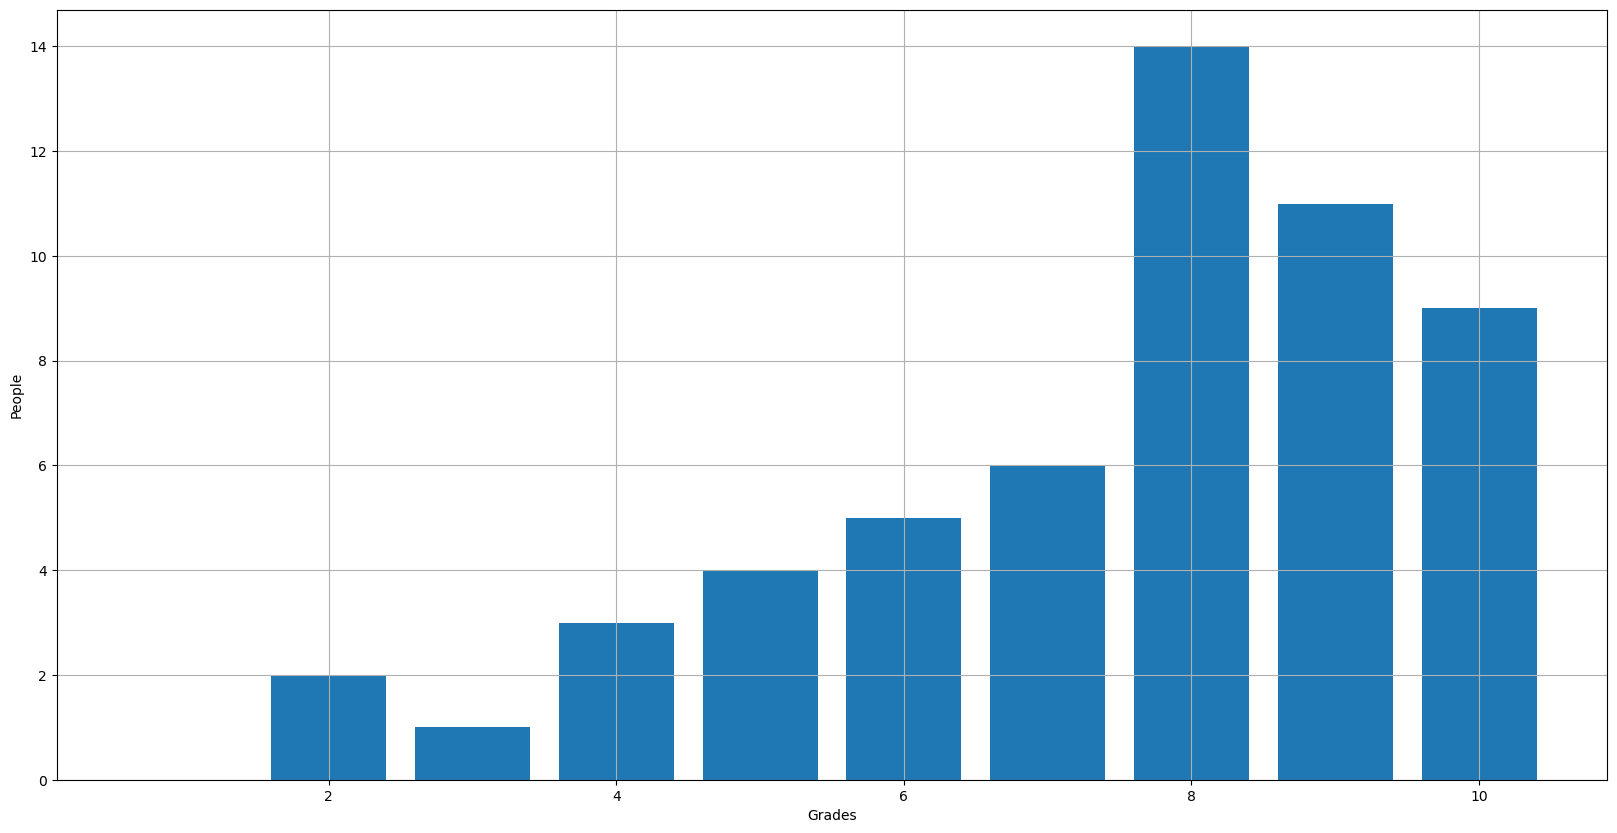

In [13]:
# You can plot here
# print((does_wells[grades==10]).sum())
# print((does_wells[grades==1]).sum())
grades_ = np.unique(grades)
values = np.zeros(grades_.shape)
for g, v in zip(grades, does_wells):
    values[g-1] += v
    
print("People who had 10 for the assignment: {}".format(int(values[-1])))
print("People who had 1 for the assignment: {}".format(int(values[0])))

plt.bar(grades_, values)
plt.grid(True)
plt.xlabel('Grades')
plt.ylabel('People')

## Polynomial linear regression


### Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\mathbf{x}$ and $\mathbf{t}$, where $\mathbf{x}$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\mathbf{t}$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$. You can make use of `np.random.normal()` (Hint: Double check its input parameters).


In [14]:
def gen_sine(n):
    # YOUR CODE HERE
    x = np.linspace(0, 2 * np.pi, n)
    sigma = 0.25
    mu = np.sin(x)
    t = np.random.normal(mu, 0.25, n)
    return x, t

In [15]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\mathbf{w}$ is:

$E(\mathbf{w}) = \frac{1}{2} (\mathbf{\Phi} \mathbf{w} - \mathbf{t})^T(\mathbf{\Phi} \mathbf{w} - \mathbf{t})$

where $\mathbf{\Phi}$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\mathbf{t}$ is the vector of target values. Your method should return a vector $\mathbf{w}$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\mathbf{\Phi}$.

In [16]:
def designmatrix(x, M): # it is highly recommended to write a helper function that computes Phi
    if x.ndim == 1:
        x = x[:, None]
    design_matrix = np.ones((x.shape[0], 1))
    for degree in range(1, M + 1):
        design_matrix = np.hstack((design_matrix, x**degree))
#     print(design_matrix)
    return design_matrix

def fit_polynomial(x, t, M):
    # YOUR CODE HERE
    Phi = designmatrix(x, M)
    w_ml = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t 
    return w_ml, Phi


In [17]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



### Plot (check yourself)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

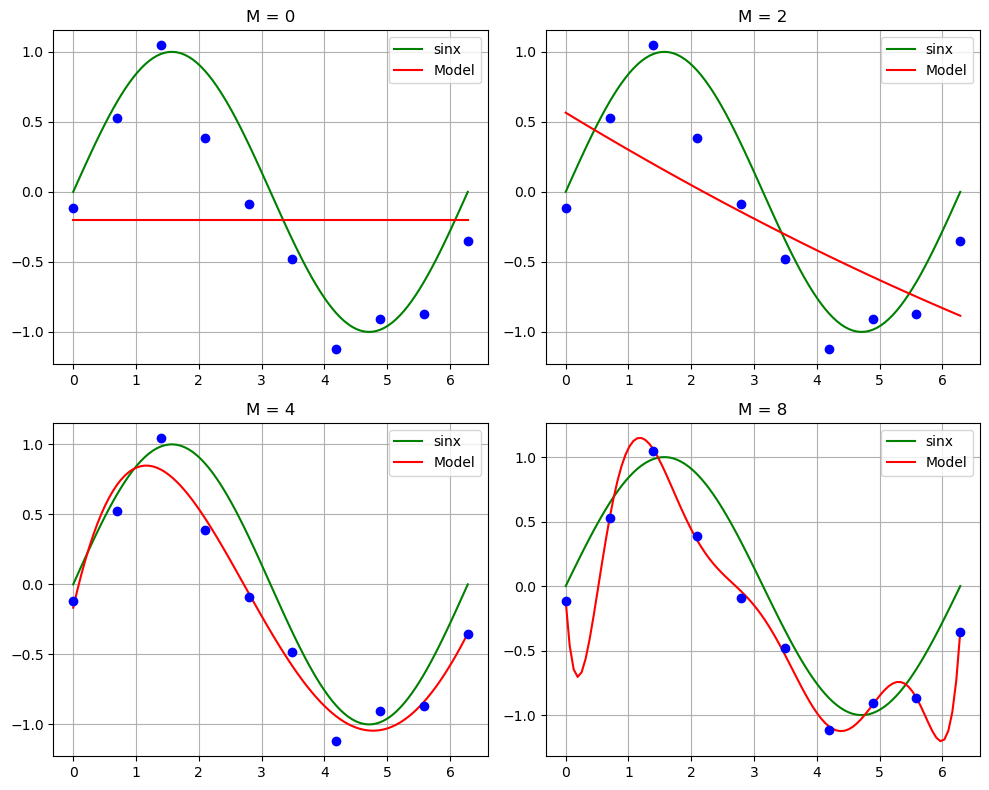

In [18]:
# x = np.linspace(0, 2 * np.pi, 10)
x_axis = np.linspace(0, 2 * np.pi, 100)
t = np.sin(x_axis) 
x_gen, t_gen = gen_sine(10)

max_order = [0, 2, 4, 8]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, order in enumerate(max_order):
    w_ml, Phi = fit_polynomial(x_gen, t_gen, order)
    row = i // 2
    col = i % 2
    axs[row, col].plot(x_axis, t, label='sinx', color='green')
    axs[row, col].plot(x_axis, designmatrix(x_axis, order) @ w_ml, label='Model', color='red')
    axs[row, col].plot(x_gen, t_gen, 'bo')
    axs[row, col].set_title('M = {}'.format(order))
    axs[row, col].legend()
    axs[row, col].grid(True)
plt.tight_layout()
plt.show()

### Regularized linear regression (10 points)

Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\mathbf{w}$:

$E(\mathbf{w}) = \frac{1}{2} (\mathbf{\Phi}\mathbf{w}- \mathbf{t})^T(\mathbf{\Phi}\mathbf{w}- \mathbf{t}) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$


The function should return $\mathbf{w}$ and $ \mathbf{\Phi} $.

In [19]:
def fit_polynomial_reg(x, t, m, lamb):
    # YOUR CODE HERE
    Phi = designmatrix(x, m)
    w_ml = np.linalg.inv(lamb * np.identity(Phi.shape[1]) + Phi.T @ Phi) @ Phi.T @ t 
    
    return w_ml, Phi


In [20]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



## Bayesian Linear (Polynomial) Regression


### Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [21]:
def gen_sine2(n):
    x = np.random.uniform(0, 2 * np.pi, n)
    sigma = 0.25
    mu = np.sin(x)
    t = np.random.normal(mu, 0.25, n)
    return x, t

In [22]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\mathbf{w} \;|\; \alpha) = \mathcal{N}(\mathbf{w} \;|\; 0, \alpha^{-1} \mathbf{I})$$

The covariance and mean of the posterior are given by:

$$\mathbf{S}_N= \left( \alpha \mathbf{I} + \beta \mathbf{\Phi}^T \mathbf{\Phi} \right)^{-1} $$
$$\mathbf{m}_N = \beta\; \mathbf{S}_N \mathbf{\Phi}^T \mathbf{t}$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\mathbf{m}_N$ and covariance $\mathbf{S}_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\mathbf{\Phi}$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [23]:
def fit_polynomial_bayes(x, t, M, alpha, beta):
    # YOUR CODE HERE
    Phi = designmatrix(x, M)
    S = np.linalg.inv(alpha * np.identity(Phi.shape[1]) + beta * Phi.T @ Phi)
    m = beta * S @ Phi.T @ t

    return m, S, Phi


In [24]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \mathbf{x}, \mathbf{t}, \alpha, \beta) = \mathcal{N}(t \;|\; \mathbf{m}_N^T \phi(\mathbf{x}), \sigma_N^2(\mathbf{x}))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\mathbf{x})^T \mathbf{S}_N \phi(\mathbf{x}) $$

where $\phi(\mathbf{x})$ are the computed features for a new datapoint $\mathbf{x}$, and $t$ is the predicted variable for datapoint $\mathbf{x}$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\mathbf{\Phi}$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [25]:
def predict_polynomial_bayes(x, m, S, beta):
    # YOUR CODE HERE
    N = len(x)
    mean = np.zeros(N)  # Initialize mean as a zero array with shape (N,)
    sigma = np.zeros(N)  # Initialize sigma as a zero array with shape (N,)
    Phi = np.zeros((N, S.shape[1])) 
    
    for i, feat in enumerate(x):
        Phi_feat = designmatrix(np.array([feat]), S.shape[1] - 1)
        mean_feat = Phi_feat.dot(m)
        sigma_feat = 1 / beta + Phi_feat @ S @ Phi_feat.T
        mean[i] = mean_feat
        sigma[i] = sigma_feat
        Phi[i, :] = Phi_feat
    
    return mean, sigma, Phi

In [26]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



### Plot predictive distribution (test yourself)

Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and the predictive standard deviation using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.

For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression.

Display each of these 100 polynomials.

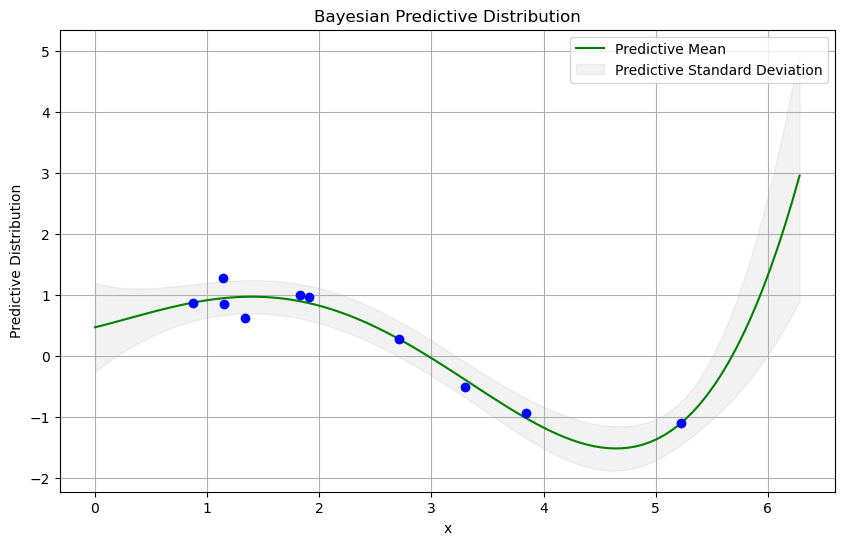

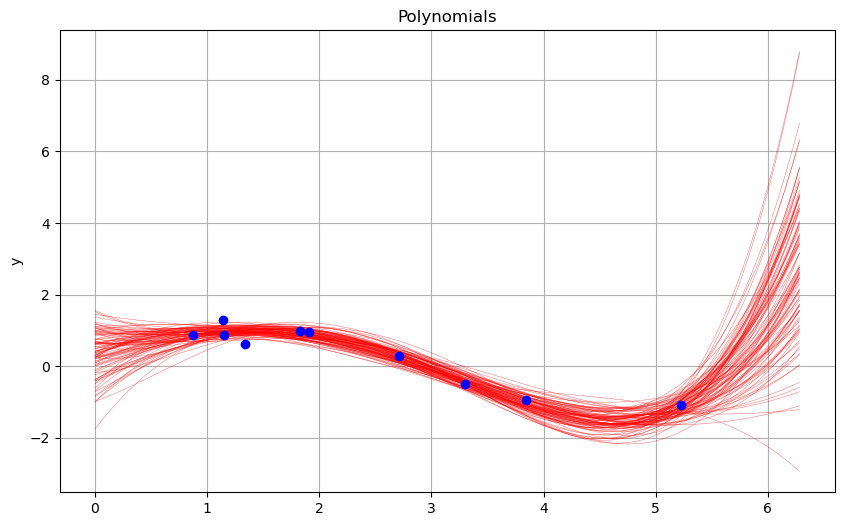

In [27]:
# You can plot here
x_axis = np.linspace(0, 2 * np.pi, 100)
x_gen, t_gen = gen_sine2(10)
m, S, Phi = fit_polynomial_bayes(x_gen, t_gen, 4, 2 / 5, 1 / ( 0.25 * 0.25))
mean, sigma, Phi_ = predict_polynomial_bayes(x_axis, m, S, beta)
# Calculate upper and lower bounds for shading
upper_bound = mean + np.sqrt(sigma)
lower_bound = mean - np.sqrt(sigma)

# Plot the Bayesian predictive distribution
plt.figure(figsize=(10, 6))
plt.plot(x_axis, mean, label='Predictive Mean', color='green')
plt.plot(x_gen, t_gen, 'bo')
plt.fill_between(x_axis, lower_bound, upper_bound, alpha=0.1, label='Predictive Standard Deviation', color='gray')
plt.xlabel('x')
plt.ylabel('Predictive Distribution')
plt.title('Bayesian Predictive Distribution')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
# Sample coefficients for the polynomial from a multivariate normal distribution
polynomial_coefficients = np.random.multivariate_normal(m, S, 100)
plt.plot(x_axis, Phi_ @ polynomial_coefficients.T, '-r', linewidth=0.2)
plt.plot(x_gen, t_gen, 'bo')
plt.ylabel('y')
plt.title('Polynomials')
plt.grid(True)
plt.show()